# Generating subspaces for the emnist dataset using PCA

In [67]:
# import mnist

import torch
import torchvision
import matplotlib.pyplot as plt
import math
%matplotlib inline

# Download MNIST dataset
emnist_train = torchvision.datasets.EMNIST('./emnist', download=True,train=True,split='digits')
emnist_val = torchvision.datasets.EMNIST('./emnist', download=True,train=False,split='digits')

In [68]:
# Lets transform each image in a vector x_i, and create list of matrices X[], each matrix for each label

X = []
n = []
for i in range(10):
    X.append(torch.empty(24000, 28*28))
    n.append(0)


for i in range(len(emnist_train)):
    X[emnist_train[i][1]][n[emnist_train[i][1]]] = torch.squeeze(torchvision.transforms.functional.to_tensor(emnist_train[i][0])).flatten()
    n[emnist_train[i][1]]+=1

In [69]:
# Calculate the average for each number

X_average = []
for i in range(10):
    X_average.append(X[i].mean(dim=0))

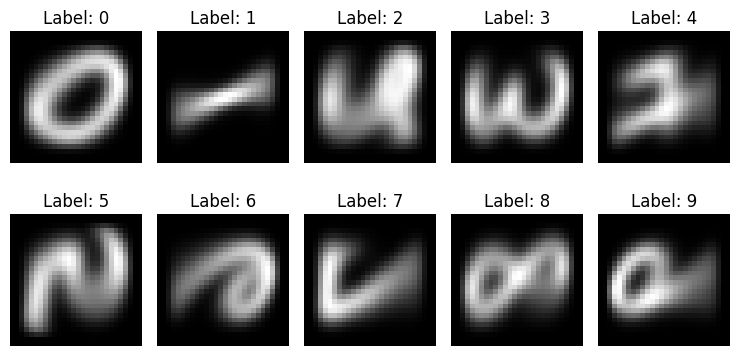

In [70]:
# Lets see these averages

fig, axes = plt.subplots(2, 5, figsize=(1.5*5,2*2))
for i in range(10):
    ax = axes[i//5, i%5]
    ax.imshow(torch.reshape(X_average[i], (28,28)), cmap='gray')
    ax.set_title('Label: {}'.format(i))
    ax.axis('off')

plt.tight_layout()
plt.show()

In [71]:
# Standardize the data matrices
for i in range(10):
    for j in range(24000):
        X[i][j]-=X_average[i]
        X[i][j]=torch.div(X[i][j], math.sqrt(28*28))
    X[i]=X[i].t()

In [72]:
# Calculate the SVD for each data matrices

U = []
S = []
V = []

for i in range(10):
    Ui, Si, Vi = torch.linalg.svd(X[i], full_matrices=False)
    U.append(Ui)
    S.append(Si)
    V.append(Vi)

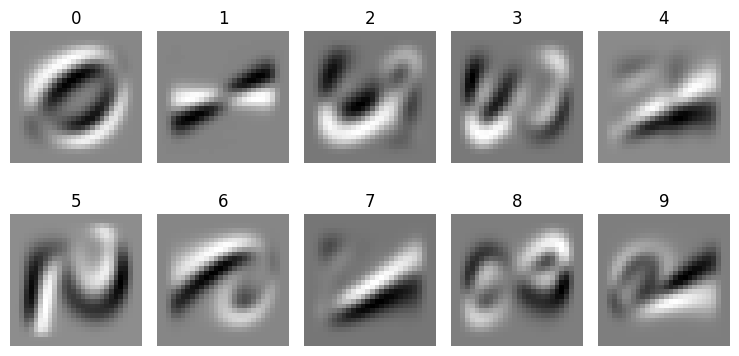

In [73]:
# now lets vizualize the first eigen-value of each class

fig, axes = plt.subplots(2, 5, figsize=(1.5*5,2*2))
for i in range(10):
    ax = axes[i//5, i%5]
    ax.imshow(torch.reshape(U[i][:,0], (28,28)), cmap='gray')
    ax.set_title('{}'.format(i))
    ax.axis('off')

plt.tight_layout()
plt.show()

In [83]:
# Lets define 10 subspaces (one for each class) using the first 10 eigenvectors of each subspace

subspaces = []
vectors_per_subspace = 20


for i in range(10):
    subspace = torch.empty(vectors_per_subspace,784)
    for j in range(vectors_per_subspace):
        subspace[j] = U[i][:,j]#*S[i][j]
    subspace = torch.transpose(subspace, 0, 1)
    subspaces.append(subspace)

# Classifying an input vector (from validation data) on each class by comparing cosine similarities

In [84]:
# Lets define a class that receives a vector input, a set of subspaces, and classifies the input into 10 classes.

def cossine_similarity(input:torch.Tensor, subspace:torch.Tensor):
    # Normalize input
    input = input.flatten()
    input -= input.mean(dim=0)
    input = torch.div(input, input.abs())

    # Sum of inner products
    S = 0
    for i in range(subspace.shape[1]):
        S+=torch.inner(input, subspace.T[i])**2  / torch.inner(input, input)
    return S

def classify_emnist(input:torch.Tensor, subspaces:list):
    S = []
    for i in range(len(subspaces)):
        S.append(cossine_similarity(input,subspaces[i]))
    return S.index(max(S))

In [85]:
# Lets evaluate the accuracy of this model

total_count = 0
error_count = 0
for i in range(len(emnist_val)):
    input = torchvision.transforms.functional.to_tensor(emnist_val[i][0])
    label = emnist_val[i][1]

    total_count+=1
    if classify_emnist(input,subspaces) != label:
        error_count+=1
    
print(f'Total number of evaluations: {total_count}\nTotal number of errors: {error_count}\nAccuracy: {(1-error_count/total_count)*100:.1f}%')

Total number of evaluations: 40000
Total number of errors: 10113
Accuracy: 74.7%


Accuracy is not that great